In [111]:
from ecell4 import *
from ecell4.extra import ensemble
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline


simrun=200
duration = 2000
#rm = 0.005
D=0.1
Nas = 5
nproc=70
L=1#cbrt(10)
k0= 0.1
rm =0.005
Nb=10

def write(name,obs):
    try:
        f=open(name,'w')
        data = np.array(obs.data()).T
        np.savetxt(name,np.column_stack([data[0],data[1]]),delimiter=',',fmt='%s')
        f.close()        
        print('saving into',name)        
    except AttributeError:
        print('no error')

def run(solver='ode',intrinsic=False,simrun=1):   
    print(solver)
    V = L**3 
    M = max(int(min(cbrt(Nas), L / (2 * rm))), 3)
    if solver=='spa':
        solver=("spatiocyte",rm)
        V=spatiocyte.SpatiocyteWorld.calculate_volume(Real3(L,L,L),rm)
    elif solver=='egfrd':
        solver = ('egfrd', Integer3(M, M, M)) 

    kon=k0/V        
    keff = kon*V*V/Nas/Nb
    kd = 4*np.pi*rm*2*D*2
    ka = keff*kd/(kd-keff)
    assert(ka>0)
    with species_attributes():
        A | {'D': D, 'radius':rm}
        B | {'D': D, 'radius':rm}

    with reaction_rules():
        ~A > A | kon
        A + B >B | (ka if intrinsic else keff)
    m = get_model()
    myseed=ensemble.genseeds(simrun)
    print('av={:.3},intrinsic={}'.format(float(V),intrinsic))
    print('kon={:.3},koff={:.3},kd={:.3},keff={:.3},kfactor={:.3}'.format(kon,(ka if intrinsic else keff),kd,keff,ka/kd))
    #obs=run_simulation(duration,model=m,y0={'B':1},return_type='observer',species_list=['A'],solver=solver,volume=ones()*L)
    jobs=[{'t':duration,'model':m,'y0':{'B':Nb},'return_type':'observer','species_list':['A'],'solver':solver,'volume':ones()*L,'myseed':myseed}]
    obs=ensemble.run_multiprocessing(ensemble.singlerun,jobs=jobs,n=simrun,nproc=nproc)
    return obs

#obs1=singlerun('ode',False,1)
#obs=run('spa',True,simrun)
obs=run('egfrd',True,simrun)
#obs4=singlerun('gillespie',False,simrun)
#write('/home/chew/outputdata/sturrock_bd_ode_rm{:.3}_Nas5'.format(rm),obs1)
#write('/home/chew/outputdata/sturrock_bd_spa_rm{:.3}_Nas5_10k'.format(rm),obs2)
#write('/home/chew/outputdata/sturrock_bd_egfrd_rm{:.3}_Nas5_10k'.format(rm),obs3)

egfrd
av=1.0,intrinsic=True
kon=0.1,koff=0.00217,kd=0.0251,keff=0.002,kfactor=0.0865


(200, 101, 2)


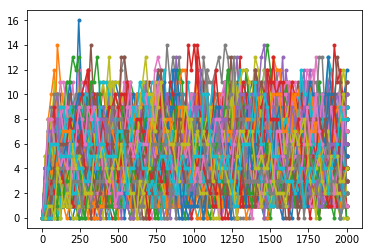

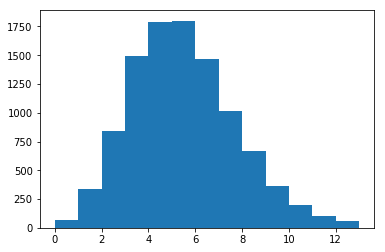

In [112]:
def plotgraph(obs):
    dat=np.array(obs[0])
    NA =np.array([])
    k=50
    print(dat.shape)
    for i in range(simrun):
        t,na=dat[i].T
        NA=np.append(NA,na[k:])
    #x,y=np.array(obs2[0][0]).T
        plt.plot(t,na,'.-')
    return NA
        
NA=plotgraph(obs)
plt.figure()
x,y,z=plt.hist(NA,bins=np.arange(0,14,1))

In [113]:
#name='/home/chew/outputdata/sturrock_bd_spa_rm{:.3}_Nas5_Nb10_distribution'.format(rm)
name='/home/chew/outputdata/sturrock_bd_egfrd_rm{:.3}_Nas5_Nb10_distribution'.format(rm)
f=open(name,'w')
np.savetxt(name,NA,delimiter=',',fmt='%s')
f.close()        
print('saving into',name)        


saving into /home/chew/outputdata/sturrock_bd_egfrd_rm0.005_Nas5_Nb10_distribution


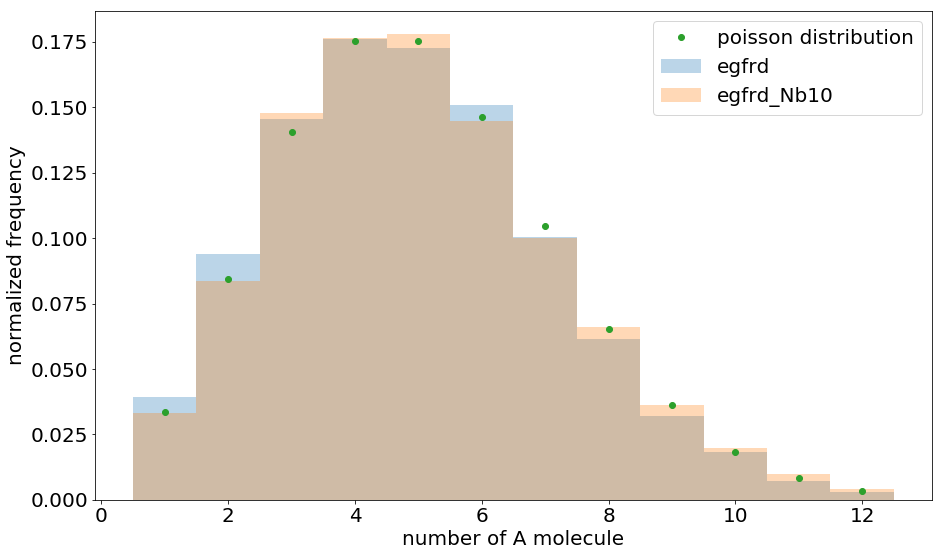

In [7]:
from ecell4 import *
from ecell4.extra import ensemble
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
rm=0.005
dat1=np.genfromtxt('/home/chew/outputdata/sturrock_bd_egfrd_rm{:.3}_Nas5_distribution'.format(rm),delimiter=',',dtype='str')
#dat2=np.genfromtxt('/home/chew/outputdata/sturrock_bd_spa_rm{:.3}_Nas5_distribution'.format(rm),delimiter=',',dtype='str')
dat2=np.genfromtxt('/home/chew/outputdata/sturrock_bd_egfrd_rm{:.3}_Nas5_Nb10_distribution'.format(rm),delimiter=',',dtype='str')
fig=plt.figure()
dat1=[float(i) for i in dat1]
dat2=[float(i) for i in dat2]
bins=np.arange(0.5,13.5,1)
xe,ye,z=plt.hist(dat1,bins=bins,alpha=0.3,normed=True,label='egfrd')
xs,ys,z=plt.hist(dat2,bins=bins,alpha=0.3,normed=True,label='egfrd_Nb10')
mean=5
mid=0.5*(ys[1:]+ys[:-1])
fc=lambda n:(mean)**n *np.exp(-mean)/math.factorial(n)
plt.plot(mid,[fc(i) for i in mid],'o',label='poisson distribution')
#plt.plot(dat2[:,0],dat2[:,1],'.', markersize=10, label='spatiocyte (r={})'.format(rm))
#plt.plot(dat3[:,0],dat3[:,1],'.',markersize=10,  label='egfrd (r={})'.format(rm))
#plt.plot(dat4[:,0],dat4[:,1],'kx',markersize=10, label='egfrd (r={}) largeBsmallA'.format(rm))
plt.tick_params(labelsize=20)
s=20
plt.legend(loc='best',fontsize=20)
plt.ylabel('normalized frequency',fontsize=s)
plt.xlabel('number of A molecule',fontsize=s)
fig.set_size_inches(15, 9)
#plt.savefig('/home/chew/ecellwork/figure/sturrock_birth_death_rm{}_Nas5_stationaryDistribution.png'.format(rm))

In [108]:
ms=sum([i*j for i,j in zip(xs,ys)])/sum(xs)
me=sum([i*j for i,j in zip(xe,ye)])/sum(xe)
print(ms,me)

4.61755392836 4.41421204007


In [4]:
d2=np.genfromtxt('/home/chew/outputdata/sturrock_bd_spa_rm0.005_run2',delimiter=',',dtype='str')
d1=np.genfromtxt('/home/chew/outputdata/sturrock_bd_spa_rm0.005',delimiter=',',dtype='str')

In [21]:
dat3=np.array([0.5*(float(x)+float(y)) for x,y in zip(d2[:,1],d1[:,1])])

In [14]:
t=[float(x) for x in d1[:,0]]
print(t)

[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0, 190.0, 200.0, 210.0, 220.0, 230.0, 240.0, 250.0, 260.0, 270.0, 280.0, 290.0, 300.0, 310.0, 320.0, 330.0, 340.0, 350.0, 360.0, 370.0, 380.0, 390.0, 400.0, 410.0, 420.0, 430.0, 440.0, 450.0, 460.0, 470.0, 480.0, 490.0, 500.0, 510.0, 520.0, 530.0, 540.0, 550.0, 560.0, 570.0, 580.0, 590.0, 600.0, 610.0, 620.0, 630.0, 640.0, 650.0, 660.0, 670.0, 680.0, 690.0, 700.0, 710.0, 720.0, 730.0, 740.0, 750.0, 760.0, 770.0, 780.0, 790.0, 800.0, 810.0, 820.0, 830.0, 840.0, 850.0, 860.0, 870.0, 880.0, 890.0, 900.0, 910.0, 920.0, 930.0, 940.0, 950.0, 960.0, 970.0, 980.0, 990.0, 1000.0]


In [23]:
name='/home/chew/outputdata/sturrock_bd_spa_rm0.005_run3'
f=open(name,'w')
np.savetxt(name,np.column_stack([t,dat3]),delimiter=',',fmt='%s')
f.close()